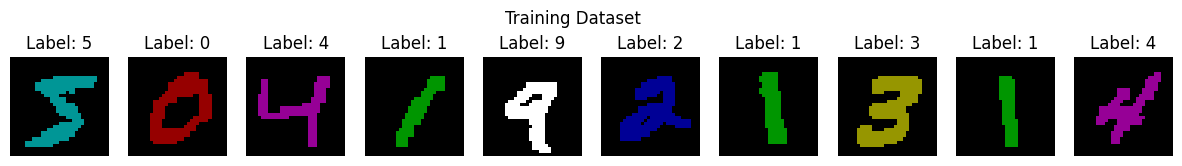

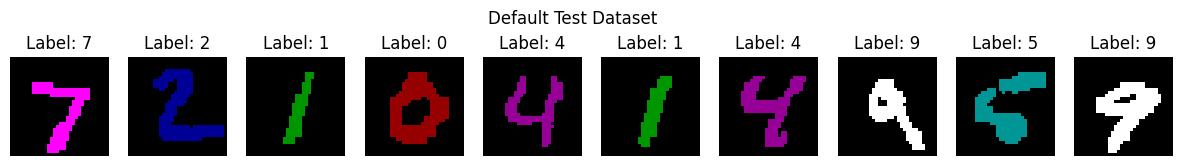

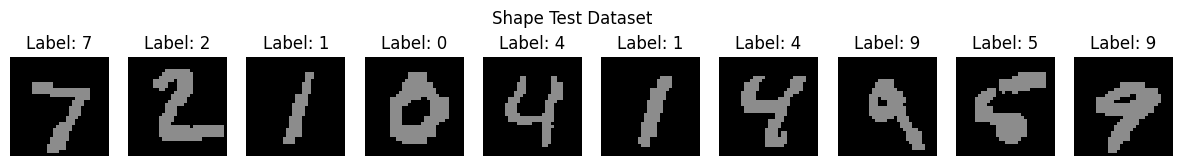

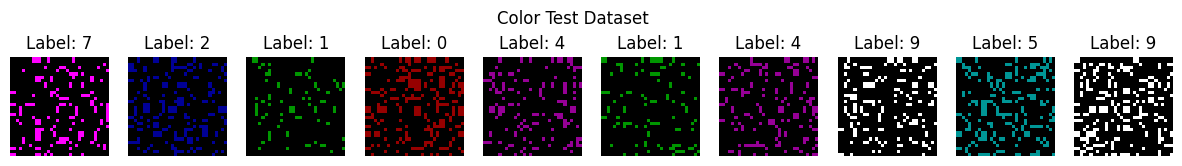

In [2]:
import numpy as np
from PIL import Image
import random
from torchvision.datasets import MNIST
from torch.utils.data import Dataset, DataLoader
import torch
import matplotlib.pyplot as plt
from dataset import *


train_data = ColoredMNIST(train=True)
test_data_default = ColoredMNIST(train=False)
test_data_shape = ColoredMNIST(train=False, test_mode='shape')
test_data_color = ColoredMNIST(train=False, test_mode='color')

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loaders = {
    'default' :  DataLoader(test_data_default, batch_size=batch_size, shuffle=False),
    'shape' :  DataLoader(test_data_shape, batch_size=batch_size, shuffle=False),
    'color' :  DataLoader(test_data_color, batch_size=batch_size, shuffle=False),
}


visualize_dataset(train_data, title="Training Dataset")
visualize_dataset(test_data_default, title="Default Test Dataset")
visualize_dataset(test_data_shape, title="Shape Test Dataset")
visualize_dataset(test_data_color, title="Color Test Dataset")


In [ ]:
from pytorch_optimizer import SOAP
from torch.nn.functional import cross_entropy
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader
from tqdm.auto import tqdm
from transformers import ViTConfig, ViTForImageClassification
from tqdm.autonotebook import tqdm as notebook_tqdm

torch.manual_seed(0)


vit = ViTForImageClassification(ViTConfig(image_size=32, num_labels=10)).cuda()
optimizer = SOAP(vit.parameters(), weight_decay=0)

epochs = 10
scheduler = ExponentialLR(optimizer, 0.1 ** (1 / epochs))

running_loss, running_accuracy = (
    torch.zeros(epochs, device='cuda'),
    torch.zeros(epochs, device='cuda'),
)
test_accuracies = {key: torch.zeros(epochs, device='cuda') for key in test_loaders}

for epoch in tqdm(range(epochs)):
    for images, labels in train_loader:
        vit.zero_grad()
        logits = vit(images.cuda()).logits
        labels = labels.cuda()
        loss = cross_entropy(logits, labels)
        running_loss[epoch] += loss.detach()
        running_accuracy[epoch] += (
            logits.detach().argmax(1) == labels
        ).sum() / batch_size
        loss.backward()
        optimizer.step()
    scheduler.step()

    for key, loader in test_loaders.items():
        total_correct = 0
        total_samples = 0
        for test_images, test_labels in loader:
            test_logits = vit(test_images.cuda()).logits
            total_correct += (test_logits.argmax(1) == test_labels.cuda()).sum().item()
            total_samples += test_labels.size(0)
        test_accuracies[key][epoch] = total_correct / total_samples


running_loss /= len(train_loader)
running_accuracy /= len(train_loader)

train_losses = running_loss.cpu().numpy().tolist()
train_accuracies = (running_accuracy.cpu().numpy() * 100).tolist()
train_metrics = {
    'loss' : train_losses,
    'accuracy' : train_accuracies
}
test_accuracies_np = {key: acc.cpu().numpy() * 100 for key, acc in test_accuracies.items()}


c:\Users\sever\OneDrive\Рабочий стол\SSL final\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
100%|██████████| 10/10 [29:01<00:00, 174.19s/it]


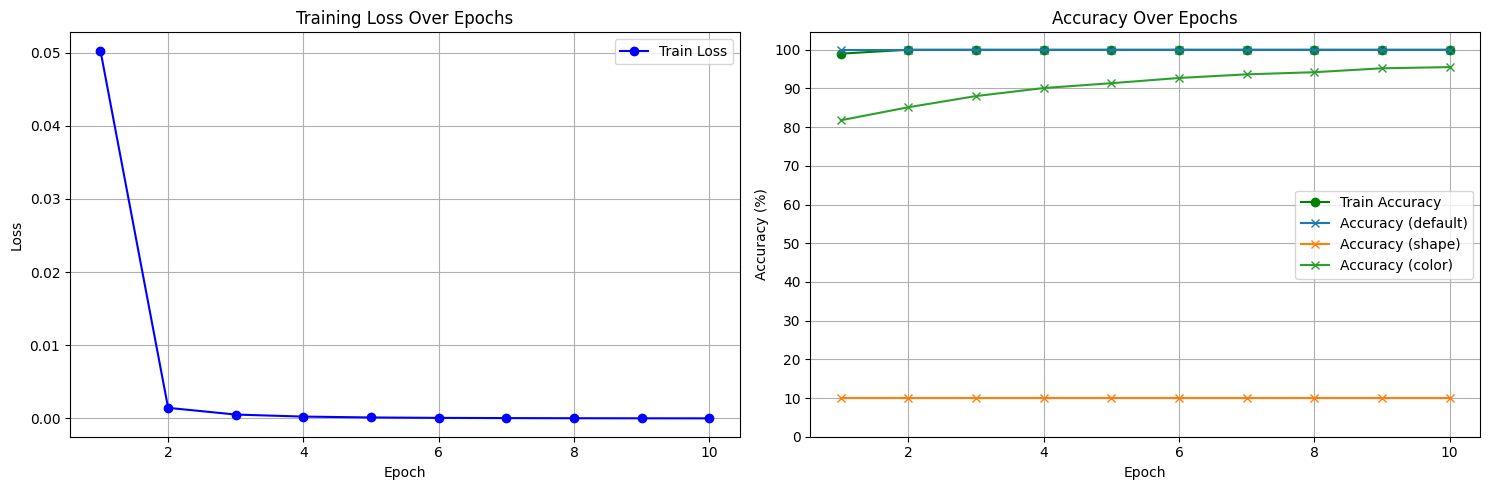

In [7]:
visualize_metrics(train_metrics, test_accuracies_np, epochs=10)